## 示例：使用决策树预测隐形眼镜类型

本节通过一个例子讲解决策树如何预测患者需要佩戴的隐形眼镜类型。使用小数据集，我们就可以利用决策树学到很多知识：眼科医生是如何判断患者需要佩戴的镜片类型；一旦理解决策树的工作原理，我们也可以帮助人们判断需要佩戴的镜片类型。

【步骤】：
- 收集数据：提供的文本文件；
- 准备数据：解析 tab 键分隔的数据行；
- 分析数据：快速检查数据，确保正确地解析数据内容，使用 create_plot() 函数绘制最终的树形图；
- 训练算法：使用先前已经准备好的 create_tree() 函数；
- 测试算法：编写测试函数验证决策树可以正确分类给定的数据实例；
- 使用算法：存储树的数据结构，以便下次使用时无需重新构造树。

隐形眼镜数据集是非常著名的数据集，它包含很多患者眼部状况的观察条件以及医生推荐的隐形眼镜类型。隐形眼镜类型包括硬材质、软材质以及不适合佩戴隐形眼镜。数据来源于 UCI 数据库，为了更容易显示数据，本节对数据作了简单的更改。

### 前置准备

In [12]:
from math import log
import operator
from matplotlib import pyplot as plt


def calc_shannon_ent(dataset):
    num_entries = len(dataset)
    label_counts = {}
    for feat_vec in dataset:
        current_label = feat_vec[-1]
        if current_label not in label_counts.keys():
            label_counts[current_label] = 0
        label_counts[current_label] += 1
    shannon_ent = 0.0
    for key in label_counts:
        prob = float(label_counts[key]) / num_entries
        shannon_ent -= prob * log(prob, 2)
    return shannon_ent


def split_dataset(dataset, axis, value):
    ret_dataset = []
    for feat_vec in dataset:
        if feat_vec[axis] == value:
            reduced_feat_vec = feat_vec[:axis]
            reduced_feat_vec.extend(feat_vec[axis + 1:])
            ret_dataset.append(reduced_feat_vec)
    return ret_dataset


def choose_best_feature_to_split(dataset):
    num_features = len(dataset[0]) - 1
    # 计算整个数据集的原始想农熵
    base_entropy = calc_shannon_ent(dataset)
    best_info_gain, best_feature = 0.0, -1
    for i in range(num_features):
        feat_list = [example[i] for example in dataset]
        # 创建唯一的分类标签列表
        unique_vals = set(feat_list)
        new_entropy = 0.0
        # 计算每种划分方式的信息熵
        for value in unique_vals:
            sub_dataset = split_dataset(dataset, i, value)
            prob = len(sub_dataset) / float(len(dataset))
            new_entropy += prob * calc_shannon_ent(sub_dataset)
        info_gain = base_entropy - new_entropy
        # 计算最好的信息增益
        if info_gain > best_info_gain:
            best_info_gain, best_feature = info_gain, i
    return best_feature


def majority_cnt(class_list):
    class_count = {}
    for vote in class_list:
        if vote not in class_count.keys():
            class_count[vote] = 0
        class_count[vote] += 1
    sorted_class_count = sorted(class_count.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_class_count[0][0]


def create_tree(dataset, labels):
    class_list = [example[-1] for example in dataset]
    # 类别完全相同则停止继续划分
    if class_list.count(class_list[0]) == len(class_list):
        return class_list[0]
    # 遍历完所有特征时返回出现次数最多的类别
    if len(dataset[0]) == 1:
        return majority_cnt(class_list)
    # 找寻最好的属性，进行划分
    best_feat = choose_best_feature_to_split(dataset)
    best_feat_label = labels[best_feat]
    # 得到列表包含的所有属性值
    my_tree = {best_feat_label: {}}
    del(labels[best_feat])
    feat_values = [example[best_feat] for example in dataset]
    unique_vals = set(feat_values)
    # 遍历当前选择特征包含的所有属性值，在每个数据集划分上递归调用函数 create_tree()
    for value in unique_vals:
        sub_labels = labels[:]
        # 得到的返回值将被插入到字典变量 my_tree 中。
        my_tree[best_feat_label][value] = create_tree(split_dataset(dataset, best_feat, value), sub_labels)
    return my_tree


# 定义文本框和箭头格式
decision_node = dict(boxstyle='sawtooth', fc='0.8')
leaf_node = dict(boxstyle='round4', fc='0.8')
arrow_args = dict(arrowstyle='<-')


def plot_tree(my_tree, parent_pt, node_txt):
    # 计算树的宽和高
    num_leafs = get_num_leafs(my_tree)
    depth = get_tree_depth(my_tree)
    first_str = list(my_tree.keys())[0]
    # 计算树节点的摆放位置，绘制在水平方向和垂直方向的中心位置
    cntr_pt = (plot_tree.xOff + (1.0 + float(num_leafs)) / 2.0 / plot_tree.totalW, plot_tree.yOff)
    # 进行文本和节点绘制
    plot_mid_text(cntr_pt, parent_pt, node_txt)
    plot_node(first_str, cntr_pt, parent_pt, decision_node)
    second_dict = my_tree[first_str]
    # 按比例减少 plot_tree.yOff
    plot_tree.yOff = plot_tree.yOff - 1.0 / plot_tree.totalD
    for key in second_dict.keys():
        if type(second_dict[key]).__name__ == 'dict':
            plot_tree(second_dict[key], cntr_pt, str(key))
        else:
            plot_tree.xOff = plot_tree.xOff + 1.0 / plot_tree.totalW
            plot_node(second_dict[key], (plot_tree.xOff, plot_tree.yOff), cntr_pt, leaf_node)
            plot_mid_text((plot_tree.xOff, plot_tree.yOff), cntr_pt, str(key))
    plot_tree.yOff = plot_tree.yOff + 1.0 / plot_tree.totalD

    
def plot_node(node_txt, center_pt, parent_pt, node_type):
    # 绘制带箭头的注解
    create_plot.ax1.annotate(node_txt, xy=parent_pt, xycoords='axes fraction', 
                            xytext=center_pt, textcoords='axes fraction', va='center', ha='center', 
                             bbox=node_type, arrowprops=arrow_args)

    
def get_num_leafs(my_tree):
    num_leafs = 0
    first_str = list(my_tree.keys())[0]
    second_dict = my_tree[first_str]
    for key in second_dict.keys():
        if type(second_dict[key]).__name__ == 'dict':
            num_leafs += get_num_leafs(second_dict[key])
        else:
            num_leafs += 1
    return num_leafs
    

def get_tree_depth(my_tree):
    max_depth = 0
    first_str = list(my_tree.keys())[0]
    second_dict = my_tree[first_str]
    for key in second_dict.keys():
        if type(second_dict[key]).__name__ == 'dict':
            this_depth = 1 + get_tree_depth(second_dict[key])
        else:
            this_depth = 1
        if this_depth > max_depth:
            max_depth = this_depth
    return max_depth
    
    
def plot_mid_text(cntr_pt, parent_pt, txt_string):
    x_mid = (parent_pt[0] - cntr_pt[0]) / 2.0 + cntr_pt[0]
    y_mid = (parent_pt[1] - cntr_pt[1]) / 2.0 + cntr_pt[1]
    create_plot.ax1.text(x_mid, y_mid, txt_string)
    

def create_plot(in_tree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    create_plot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plot_tree.totalW = float(get_num_leafs(in_tree))
    plot_tree.totalD = float(get_tree_depth(in_tree))
    plot_tree.xOff = -0.5 / plot_tree.totalW
    plot_tree.yOff = 1.0
    plot_tree(in_tree, (0.5, 1.0), '')
    plt.show()

In [3]:
with open('data/lenses.txt') as file:
    lenses = [inst.strip().split('\t') for inst in file.readlines()]
    lenses_labels = ['age', 'prescript', 'astigmatic', 'tearRate']
    lenses_tree = create_tree(lenses, lenses_labels)

In [4]:
lenses_tree

{'tearRate': {'normal': {'astigmatic': {'no': {'age': {'pre': 'soft',
      'presbyopic': {'prescript': {'myope': 'no lenses', 'hyper': 'soft'}},
      'young': 'soft'}},
    'yes': {'prescript': {'myope': 'hard',
      'hyper': {'age': {'pre': 'no lenses',
        'presbyopic': 'no lenses',
        'young': 'hard'}}}}}},
  'reduced': 'no lenses'}}

采用文本方式很难分辨出决策树的模样，我们再调用 create_plot() 函数绘制树形图。

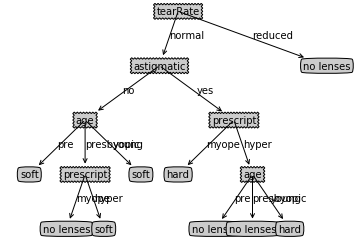

In [13]:
create_plot(lenses_tree)

上图所示的决策树非常好地匹配了实验数据，然而这些匹配选项可能太多了。我们将这种问题称之为过度匹配（overfitting）。为了减少过度匹配问题，我们可以裁剪决策树，去掉一些不必要的叶子节点。如果叶子节点只能增加少许信息，则可以删除该节点，将它并入到其他叶子节点中。